# Scraping Twitter Data

In [5]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from collections import Counter
from config import *
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize
import string
import unidecode

#Import the necessary methods from tweepy library
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy import API
from tweepy import Cursor
import json
import datetime

#wordcloud
from wordcloud import WordCloud, ImageColorGenerator
import re

from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words("english"))
ps = PorterStemmer()

In [6]:
## access token informations 
access_token1 = "1713827162-u7FwIX40Ik9ZOGFdOhvQ8ptdeFkYDgD7D9vykV9"
access_token_secret1 = "6G55EqsADCYfTNFxA1Nq6apNqszSXLkovDHXuhppWdLLt"

consumer_key1 = "iO6qKvIwdpcEs8tdhAVKZPBa7"
consumer_secret1 = "TYyl5uKremIto1YD0nsF7HkfwoOIRpjpCHJjmHgzzHKwKSOUkh"

auth = OAuthHandler(consumer_key1, consumer_secret1)
auth.set_access_token(access_token1, access_token_secret1)
api = API(auth_handler=auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# Streaming API

In [7]:
class MyStreamListener(StreamListener):
    """
    Twitter listener, collects streaming tweets and output to a file
    """
    def __init__(self, api, OUTPUT_FILENAME, stop_condition=10):
        """
        initialize the stream, with num. of tweets and saving the outputfile
        """
        
        # this line is needed to import the characteristics of the streaming API
        super(MyStreamListener, self).__init__()
        
        # to-count the number of tweets collected        
        self.num_tweets = 0
        
        # save filename
        self.filename = OUTPUT_FILENAME
        
        # stop-condition
        self.stop_condition = stop_condition
        

    def on_status(self, status):
        
        """
        this function runs each time a new bunch of tweets is retrived from the streaming
        """
        
        with open(self.filename, "a+") as f:
            tweet = status._json
            
            f.write(json.dumps(tweet) + '\n')
            #self.output.append(tweet)
            self.num_tweets += 1
        
            # Stop condition        
            if self.num_tweets <= self.stop_condition:
                return True
            else:
                return False
        

    def on_error(self, status):
        """
        function useful to handle errors. It's possible to personalize it 
        depending on the way we want to handle errors
        """
        
        print(status)
        #returning False in on_error disconnects the stream
        return False

In [ ]:
%%time

OUTPUT_FILENAME = "one.json"
stop_condition = 100000

l = MyStreamListener(api, OUTPUT_FILENAME, stop_condition)
# here we recall the Stream Class from Tweepy to input the authentication info and our personalized listener 
stream = Stream(auth=api.auth, listener=l)


# keywords we may want decide to track 
TRACKING_KEYWORDS = ["#covid19","#Covid19","#COVID19","#covid","#coronavirus","#pcr","#Covid-19","#quarantine","confinement"
                     ,"Covid19","coronavirus","COVID19","PCR","Covid-19","#Covid-19", "Coronavirus","Antibody",
                     "Social distancing","epidemic","pandemic","Asymptomatic","vaccine","SARSCOV2", "pandemic", 
                    "pneumonia", "lockdown", "pfizer", "moderna", "astrazeneca","biontech", "sanofi", 
            "J&J", "vaccine", "dispnea", "die"]



stream.filter(
    track=TRACKING_KEYWORDS, 
    is_async=False, 
    languages = ["en"]
)

## A. Data structure

In [5]:
def print_retweets_uniqueTweets_uniqueUsers(df_tweets):
    retweets_ = df_tweets["retweeted_status"].apply(lambda x: 0 if str(x) == 'nan' else 1)
    tot_retweets = sum(retweets_)
    unique_tweets = len(retweets_) - tot_retweets
    
    users_ = df_tweets.user.apply(lambda x: x['id'])
    
    tot_users = len(set(users_))
    
    print("Tot Retweets")
    print(tot_retweets)

    print("Unique Tweets")
    print(unique_tweets)
    
    print("Unique Users")
    print(tot_users)

In [6]:
with open("one.json", "rb") as f:
    data = f.readlines()
    data = [json.loads(str_) for str_ in data]
    
df_tweets = pd.DataFrame.from_records(data)
print_retweets_uniqueTweets_uniqueUsers(df_tweets)

Tot Retweets
45734
Unique Tweets
23727
Unique Users
52502


In [7]:
def extract_hashtags():
    """
    
    """
    
    hashtags_lists = df_tweets["entities"].apply(lambda x: x['hashtags'])
    
    hashtags = hashtags_lists.apply(lambda x: x[0]['text'].lower() if x != [] else None)
    
    hashtags_by_frequency = Counter(hashtags)
    hashtags_by_frequency = {k: hashtags_by_frequency[k] for k in hashtags_by_frequency if k != None}
    
    return hashtags_by_frequency

/Users/joan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/joan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


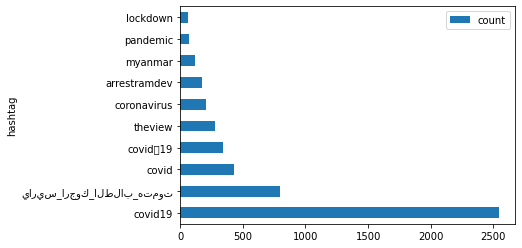

In [8]:
hashtags_by_frequency = extract_hashtags()
df_hashtags = pd.DataFrame(hashtags_by_frequency.items())
df_hashtags.columns = ["hashtag", "count"]
df_hashtags.set_index("hashtag", inplace=True)
df_hashtags.sort_values("count", inplace=True, ascending=False)
df_hashtags.head(10).plot.barh()
plt.show()

Let's plot the top-5 frequent hashtags now

# B. Wordcloud

In [9]:
def plot_wordcloud(title, dic_):
    fig, ax = plt.subplots(1, 1, figsize=(18,7))
    wordcloud = WordCloud(background_color="white",width=1600, height=800)
    wordcloud = wordcloud.generate_from_frequencies(dic_)
    ax.axis("off")     
    ax.imshow(wordcloud, interpolation='bilinear')

    ax.set_title(title)
    plt.tight_layout()
    fig.subplots_adjust(top=0.8)
    plt.show()

In [10]:
def remove_links(text):
    if text:
        return re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)
    
    # In case there is no text
    return ""

def remove_hashtags(text):
    if text:
        return re.sub(r'#\w+ ?', '', text)
    
    return ""
def remove_accents(text):
    if text:
        return unidecode.unidecode(text)
        

    # In case there is no text
    return ""

def remove_punctuation_marks(text):
    if text:
        translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
        new_text = text.translate(translator)
        return " ".join(new_text.split())
        
    # In case there is no text
    return ""

def text_to_lower_case(text):
    if text:
        return text.lower()
    
    # In case there is no text
    return ""

def remove_emojis(text):
    if text:
        # TODO: Remove emojis (tip: search for encode - decode)
        returnString = ""
        for character in text:
            try:
                character.encode("ascii")
                returnString += character
            except UnicodeEncodeError:
                returnString += ''
        text = " ".join(returnString.split())
        
    return text

    # In case there is no text
    return ""

def remove_multiple_whitespaces(text):
    if text:
        return " ".join(text.split())

    # In case there is no text
    return ""

def remove_text_marks(text):
    if text:
        text = text.translate(str.maketrans('', '', string.punctuation))
        
        # TODO: replace *, ?, ... by spaces
        
        return text.strip()
    
    # In case there is no text
    return ""

def split_text_and_numbers(text):
    temp = re.compile("([a-zA-Z]+)([0-9]+)") 
    try:
        res = temp.match(text).groups()
        text = " ".join(res)
    except:
        text = text
    return text

def remove_alone_numbers(text):
    if text:
        text = ' '.join(filter(lambda word:word.replace('.','').isdigit()==False, text.split()))
        
        return text
    
    return ""

def remove_stopwords(text):
    text = text.split()
    return " ".join([x for x in text if x not in STOPWORDS])

def stemming(text):
    text = text.split()
    return " ".join([ps.stem(x) for x in text])

def clean_text(text):
    # Apply the different functions in order to clean the text
    text = remove_links(text)
    text = remove_hashtags(text)
    text = text_to_lower_case(text)
    text = remove_text_marks(text)
    text = remove_accents(text)
    text = remove_emojis(text)
    text = split_text_and_numbers(text)
    #text = remove_alone_numbers(text)
    text = remove_multiple_whitespaces(text)
    text = remove_punctuation_marks(text)
    text = remove_stopwords(text)
    text = stemming(text)
    
    # Return
    return text

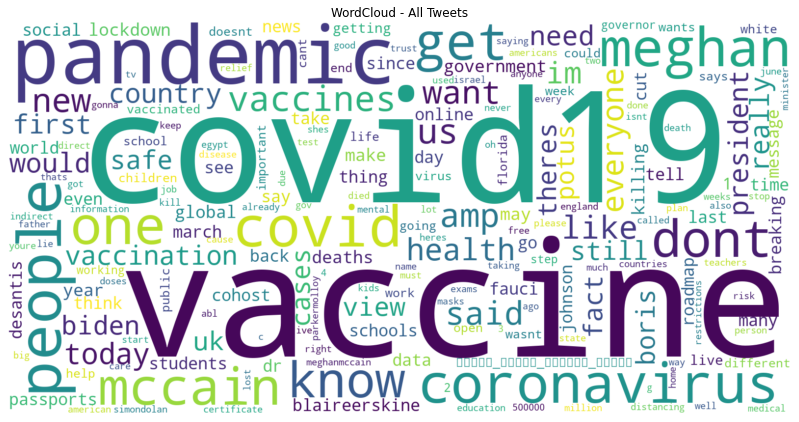

In [11]:
bag_of_words = {}
for text in df_tweets["text"]:
    
    # remove "RT" string indicating a retweet
    text = text.replace("RT ", "").strip()
    
    # lowering text
    text = text.lower()
    
    # removing all the punctuations
    text = re.sub(r'[^\w\s]','', text).strip()
    
    # tokenize the text
    lst_text = text.split()
    
    # remove stopwords
    lst_text = [x for x in lst_text if x not in STOPWORDS]
    
    #stemming
    ps = PorterStemmer() 
        
    # create bag-of-words - for each word the frequency of the word in the corpus
    for w in lst_text:
        if w not in bag_of_words:
            bag_of_words[w] = 0
        bag_of_words[w] += 1

plot_wordcloud("WordCloud - All Tweets", bag_of_words)

<BarContainer object of 10 artists>

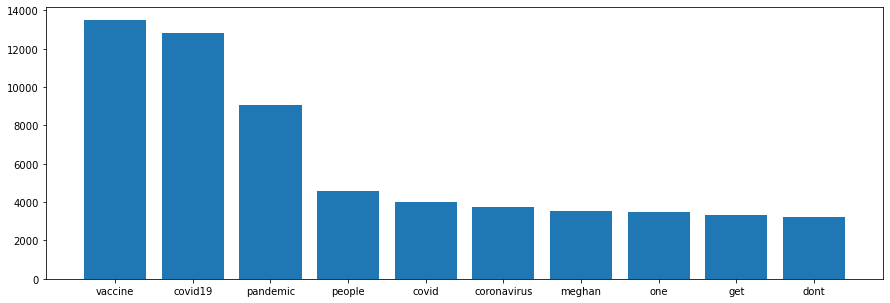

In [12]:
bag_of_words = sorted(bag_of_words.items(), key=lambda x: x[1], reverse=True)
df = pd.DataFrame(columns=['Word', 'Frequency'])
count = 0
for word, freq in bag_of_words[:10]:
    df.loc[count,'Word'] = word
    df.loc[count,'Frequency'] = freq
    count +=1

plt.figure(figsize = (15,5))
plt.bar(x = df['Word'], height =df['Frequency'])